# MRM and MRMC Confidence Checks

In [29]:
from __future__ import annotations
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))


%load_ext autoreload
%autoreload 2

from typing import Sequence, Optional, Any
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns


from models import model_interface
from data.datasets import base_loader
from data import recourse_adapter
from recourse_methods import mrmc_method
from core import recourse_iterator
from core import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup the data, model, and adapter

### Get the synthetic data

The synthetic dataset has:
* 1 negatively-classified POI at (0, 0)
* 1 positively-classified 4-point cluster at (1, 2)
* 1 positively-classified 4-point cluster at (-1, 2)

Text(0.5, 1.0, 'Synthetic Dataset')

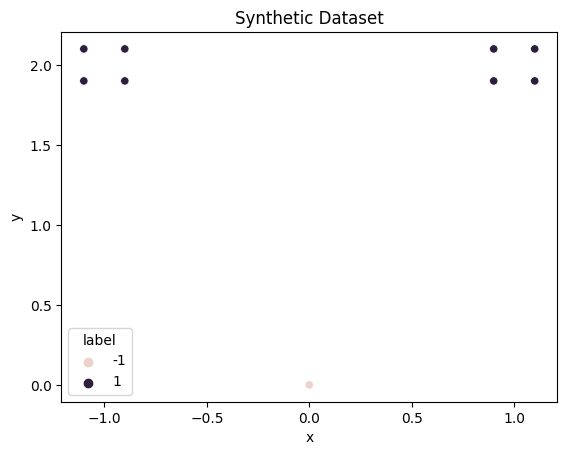

In [30]:
def get_data() -> pd.DataFrame:
    """Generates a simple synthetic dataset.
    
    * 1 negatively-classified POI at (0, 0).
    * 1 positively-classified 4-point cluster at (1, 2).
    * 1 positively-classified 4-point cluster at (-1, 2).
    """
    offsets = np.array(
        [[-0.1, -0.1], [-0.1, 0.1], [0.1, -0.1], [0.1, 0.1]]
    )
    grid_1 = np.array([[2, 1]] * 4) + offsets
    grid_2 = np.array([[2, -1]] * 4) + offsets
    POI = np.array([[0, 0]])
    data = np.concatenate([grid_1, grid_2, POI])
    labels = [1] * 8 + [-1]
    return pd.DataFrame(
        {"x": data[:, 1], "y": data[:, 0], "label": labels}
    )


DATASET = get_data()
DATASET_INFO = base_loader.DatasetInfo(
    continuous_features=["x", "y"],
    ordinal_features=[],
    categorical_features=[],
    label_column="label",
    positive_label=1
)


POI = DATASET.drop('label', axis=1).iloc[-1]
sns.scatterplot(x='x', y='y', hue="label", data=DATASET)
plt.title("Synthetic Dataset")

### Create a passthrough adapter
For ease of debugging, the adapter doesn't transform the data.

In [31]:
class PassthroughAdapter(recourse_adapter.RecourseAdapter):
    """A recourse adapter which passes through continuous data without
    altering it.

    The adapter also optionally simulates rescaling the recourse or adding
    random noise while interpreting recourse instructions.
    """

    def __init__(
        self,
        label_column: str,
        perturb_ratio: Optional[float] = None,
        rescale_ratio: Optional[float] = None,
        positive_label: Any = 1,
    ):
        super().__init__(
            label_column=label_column, positive_label=positive_label
        )
        self.columns = None
        self.perturb_ratio = perturb_ratio
        self.rescale_ratio = rescale_ratio

    def fit(self, dataset: pd.DataFrame) -> PassthroughAdapter:
        super().fit(dataset)
        self.columns = dataset.columns
        return self

    def transform(
        self, dataset: pd.DataFrame
    ) -> recourse_adapter.EmbeddedDataFrame:
        df = super().transform(dataset)
        return df

    def inverse_transform(
        self, dataset: recourse_adapter.EmbeddedDataFrame
    ) -> pd.DataFrame:
        df = super().inverse_transform(dataset)
        return df

    def directions_to_instructions(
        self, directions: recourse_adapter.EmbeddedSeries
    ) -> recourse_adapter.EmbeddedSeries:
        return directions

    def interpret_instructions(
        self, poi: pd.Series, instructions: recourse_adapter.EmbeddedSeries
    ) -> pd.Series:
        """Interprets the recourse instructions by moving the POI in the
        direction.
        
        It may also perturb or rescale the direction followed.
        """
        if self.perturb_ratio:
            instructions = utils.randomly_perturb_direction(
                instructions, self.perturb_ratio
            )
        if self.rescale_ratio:
            instructions = instructions * self.rescale_ratio
        poi = self.transform_series(poi)
        counterfactual = poi + instructions
        return self.inverse_transform_series(counterfactual)

    def column_names(self, drop_label=True) -> Sequence[str]:
        if drop_label:
            return self.columns.difference([self.label_column])
        else:
            return self.columns

    def embedded_column_names(self, drop_label=True) -> Sequence[str]:
        if drop_label:
            return self.columns.difference([self.label_column])
        else:
            return self.columns

ADAPTER = PassthroughAdapter(
    label_column=DATASET_INFO.label_column,
    positive_label=DATASET_INFO.positive_label
).fit(DATASET)

### Create a simple model

There is a low- to high-confidence gradient from (-1, 0) to (1, 2)

<AxesSubplot: title={'center': 'Model Confidence Contours'}, xlabel='x', ylabel='y'>

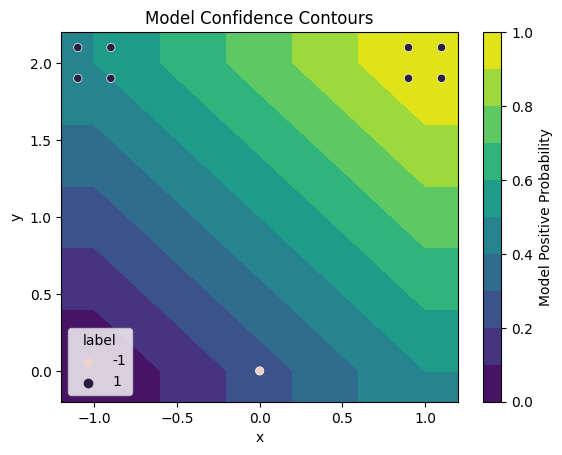

In [32]:
class SyntheticModel(model_interface.Model):
    def __init__(
        self, adapter: recourse_adapter.RecourseAdapter
    ):
        super().__init__(adapter=adapter)

    def _predict_pos_proba(
        self, dataset: recourse_adapter.EmbeddedDataFrame
    ) -> np.ndarray:
        """Predicts a probability gradient from (-1, 0) to (1, 2)"""
        x = dataset.x.to_numpy()
        y = dataset.y.to_numpy()
        output = np.empty((x.shape[0], 2))
        output[:,0] = (x+1)/2
        output[:,1] = y/2
        return np.minimum(np.maximum(output, 0), 1).mean(axis=1)

    def _predict(
        self, dataset: recourse_adapter.EmbeddedDataFrame
    ) -> np.ndarray:
        proba = self._predict_pos_proba(dataset)
        return np.where(proba > 0.5, 1, -1)

    def to_dice_model(self):
        pass


MODEL = SyntheticModel(ADAPTER)


def plot_model_confidence(model, xlim=(-1, 1), ylim=(0,2)):
    """Plots model confidence contours.
    
    Args:
        xlim: The x-axis boundaries of the confidence gradient.
        ylim: The y-axis boundaries of the confidence gradient.
    """
    # Get coordinates of a data grid
    buffer = 0.2
    x_axis = np.linspace(xlim[0] - buffer, xlim[1] + buffer, 50)
    y_axis = np.linspace(ylim[0] - buffer, ylim[1] + buffer, 50)
    x_grid, y_grid = np.meshgrid(x_axis, y_axis)

    # Convert to a standard format dataset
    grid_dataset = pd.DataFrame({'x': x_grid.flatten(), 'y': y_grid.flatten()})
    scores = model.predict_pos_proba(grid_dataset).to_numpy()
    z_grid = np.reshape(scores, x_grid.shape)

    # Plot the boundary
    plt.contourf(x_grid, y_grid, z_grid, levels=np.linspace(0, 1, 11))
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Model Positive Probability')

plot_model_confidence(MODEL)
plt.title('Model Confidence Contours')
sns.scatterplot(x='x', y='y', hue='label', data=DATASET)

# Check MRM

### Check the MRM recourse direction generation

The recourse direction should point between the two clusters

Text(0.5, 1.0, 'Recourse Direction')

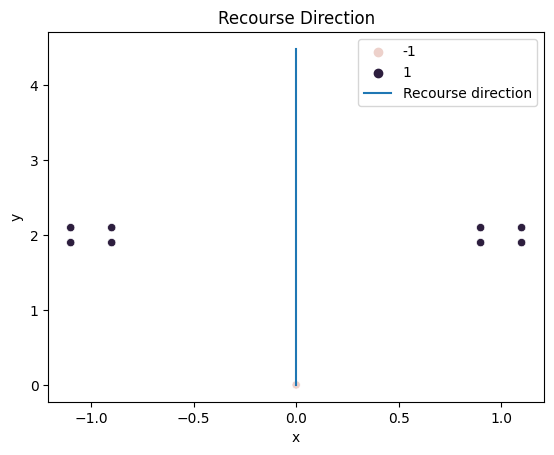

In [33]:
def simple_alpha(dist: np.ndarray) -> np.ndarray:  # passthrough alpha
    return dist

mrm = mrmc_method.MRM(DATASET, ADAPTER, alpha=simple_alpha)
x, y = mrm.get_recourse_instructions(POI)
sns.scatterplot(x='x', y='y', data=DATASET, hue='label')
plt.plot([0, x], [0, y], label='Recourse direction')
plt.legend()
plt.title("Recourse Direction")

### Check the MRM data processing

We expect to see:
1. The single negatively-classified POI at (0,0) is always filtered out
2. Datapoints below the given confidence threshold are filtered out

With `confidence_threshold = 0.1`, only the POI is removed.

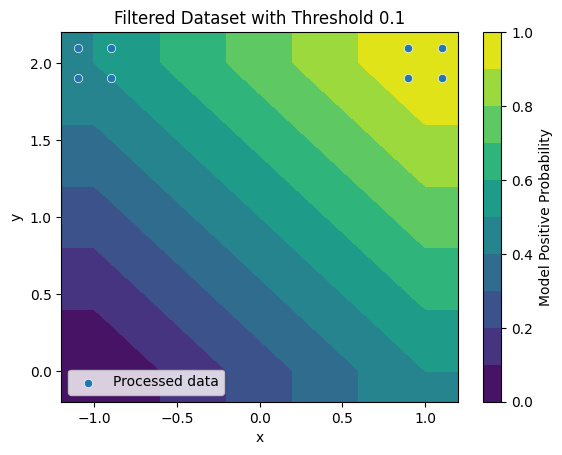

In [34]:
def plot_mrm_filtering(confidence_threshold):
    """Plot the output of mrm._process_data.
    
    Args:
        confidence_threshold: The confidence threshold to process the data with.
    """
    plot_model_confidence(MODEL)
    plt.title(f'Filtered Dataset with Threshold {confidence_threshold}')
    filtered_dataset = mrm._process_data(DATASET, ADAPTER, confidence_threshold=confidence_threshold, model=MODEL)
    sns.scatterplot(x='x', y='y', data=filtered_dataset, label="Processed data")

plot_mrm_filtering(0.1)

With `confidence_threshold = 0.5`, one point of the left cluster remains.

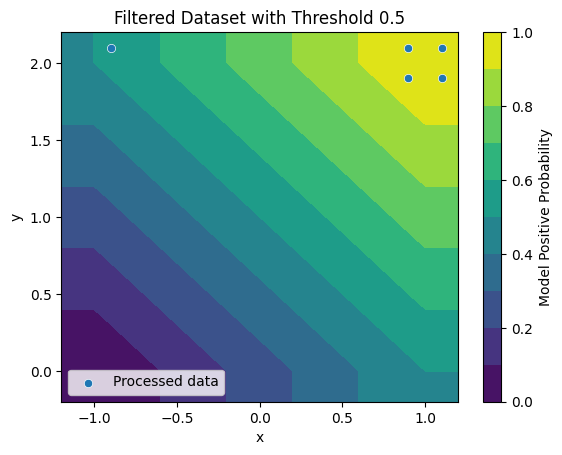

In [35]:
plot_mrm_filtering(0.5)

With `confidence_threshold = 0.9`, only the right cluster remains.

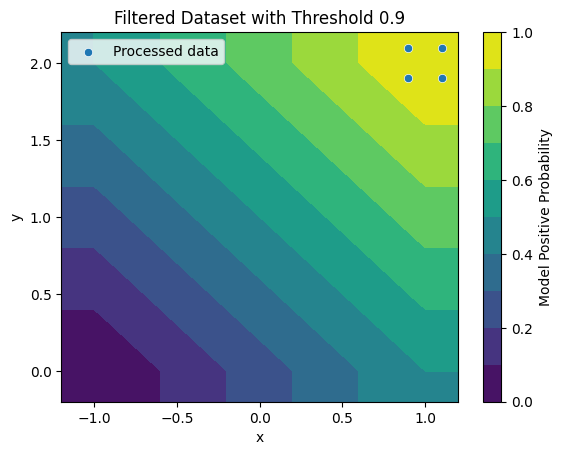

In [36]:
plot_mrm_filtering(0.9)

### Check the MRM recourse directions with confidence filtering

When only the high-confidence right cluster remains, the recourse points directly at it.

Text(0.5, 1.0, 'Recourse with Threshold 0.9')

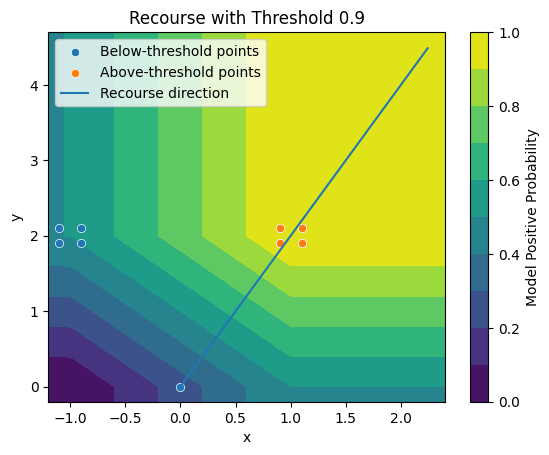

In [37]:
confidence_threshold = 0.9
mrm = mrmc_method.MRM(
    DATASET,
    ADAPTER,
    alpha=simple_alpha,
    confidence_threshold=confidence_threshold,
    model=MODEL)
x, y = mrm.get_recourse_instructions(POI)


plot_model_confidence(MODEL, xlim=(-1,2.2), ylim=(0,4.5))

processed_data = mrm._process_data(
    DATASET, ADAPTER, confidence_threshold=confidence_threshold, model=MODEL)
sns.scatterplot(x='x', y='y', data=DATASET, label="Below-threshold points")
sns.scatterplot(x='x', y='y', data=processed_data, label="Above-threshold points")

plt.plot([0, x], [0, y], label='Recourse direction')

plt.legend()
plt.title(f"Recourse with Threshold {confidence_threshold}")

When the threshold is lowered, a point from the left cluster is added and the recourse points somewhere between the clusters.

Text(0.5, 1.0, 'Recourse with Threshold 0.5')

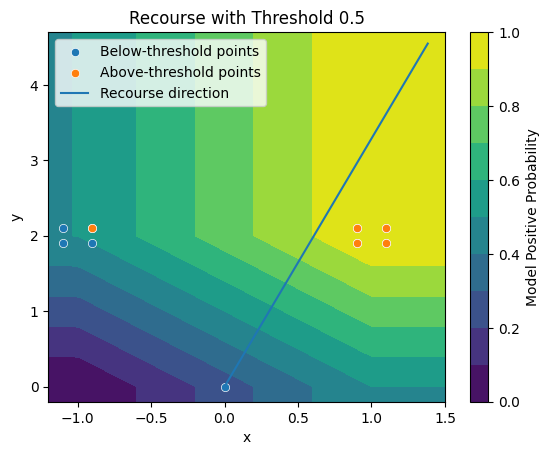

In [38]:
confidence_threshold = 0.5
mrm = mrmc_method.MRM(
    DATASET,
    ADAPTER,
    alpha=simple_alpha,
    confidence_threshold=confidence_threshold,
    model=MODEL)
x, y = mrm.get_recourse_instructions(POI)


plot_model_confidence(MODEL, xlim=(-1,1.3), ylim=(0,4.5))

processed_data = mrm._process_data(
    DATASET,
    ADAPTER,
    confidence_threshold=confidence_threshold,
    model=MODEL)
sns.scatterplot(x='x', y='y', data=DATASET, label="Below-threshold points")
sns.scatterplot(x='x', y='y', data=processed_data, label="Above-threshold points")

plt.plot([0, x], [0, y], label='Recourse direction')
plt.legend()
plt.title(f"Recourse with Threshold {confidence_threshold}")

# Check MRMC

### Check the MRMC recourse directions with confidence filtering

We expect to see MRMC:
1. Filter the dataset by confidence_threshold
2. Create two clusters for the remaining points
3. Generate one direction per cluster

In [39]:
def plot_clusters(clusters, cluster_1_color, cluster_2_color):
    """Plots points labeled according to their cluster.

    Hard-coded to use two clusters.
    
    Args:
        clusters: The Cluster class describing the clusters.
        cluster_1_color: The color to use for the first cluster.
        cluster_2_color: The color to use for the second cluster.
    """
    cluster_assignments = clusters.cluster_assignments
    # cluster 1
    cluster_1_indices = cluster_assignments[cluster_assignments.datapoint_cluster == 0].datapoint_index
    cluster_1_df = DATASET.loc[cluster_1_indices]
    sns.scatterplot(x='x', y='y', data=cluster_1_df, label="Cluster 1 points",
        color=cluster_1_color)

    # cluster 2
    cluster_2_indices = cluster_assignments[cluster_assignments.datapoint_cluster == 1].datapoint_index
    cluster_2_df = DATASET.loc[cluster_2_indices]
    sns.scatterplot(x='x', y='y', data=cluster_2_df, label="Cluster 2 points",
        color=cluster_2_color)


def plot_mrmc_directions(confidence_threshold):
    """Generates and plots MRMC recourse directions."""
    mrmc = mrmc_method.MRMC(
        k_directions=2,
        adapter=ADAPTER,
        dataset=DATASET,
        alpha=simple_alpha,
        confidence_threshold=confidence_threshold,
        model=MODEL,
    )
    direction_1, direction_2 = mrmc.get_all_recourse_instructions(POI)

    plot_model_confidence(MODEL, xlim=(-2.2,2.2), ylim=(0,5))

    sns.scatterplot(x='x', y='y', data=DATASET, label="Below-threshold points", color='red')

    plot_clusters(mrmc.clusters, 'green', 'orange')

    plt.plot([0, direction_1.x], [0, direction_1.y], label='Recourse direction 1', color='green')
    plt.plot([0, direction_2.x], [0, direction_2.y], label='Recourse direction 2', color='orange')
    plt.legend()
    plt.title(f"MRMC Recourse with Threshold {confidence_threshold}")

When there is no confidence threshold, we expect to see directions towards each cluster.

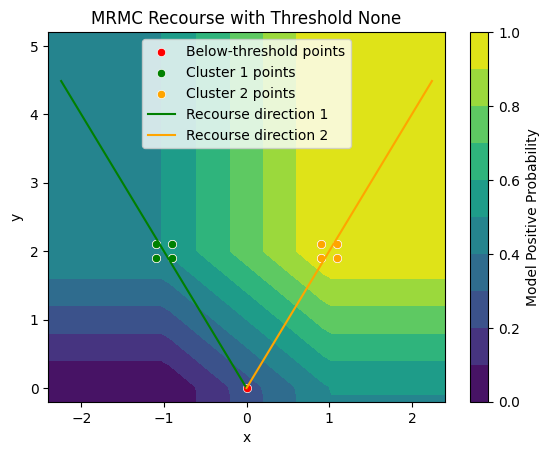

In [40]:
plot_mrmc_directions(None)

When the threshold is raised, a point from the left cluster is added and the left recourse path runs directly through it.

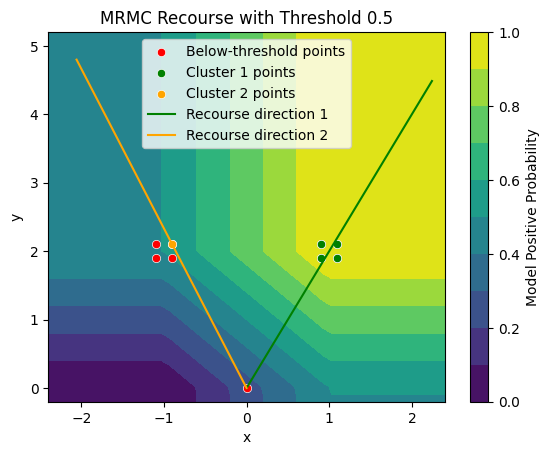

In [41]:
plot_mrmc_directions(0.5)

When the threshold is raised to 0.9, both directions point towards the right cluster.

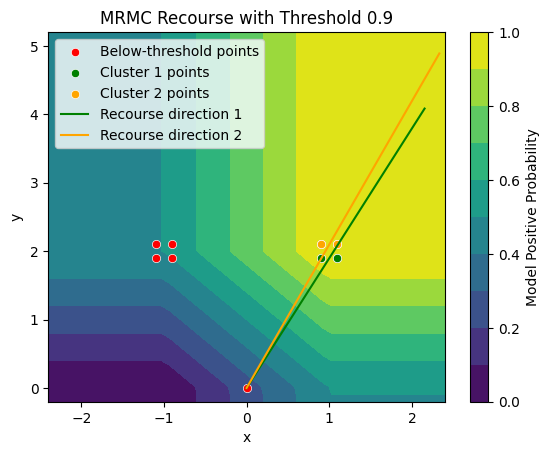

In [42]:
plot_mrmc_directions(0.9)

# Check MRMC Recourse Iteration

In [43]:
def plot_path(path: pd.DataFrame, path_color, path_index):
    """Plots a recourse path.
    
    Args:
        path: The path to plot.
        path_color: The color to use while plotting.
        path_index: The path index to use for the label.
    """
    sns.scatterplot(x='x', y='y', data=path, color='grey')
    for i in range(path.shape[0]-1):
        p1 = path.iloc[i]
        p2 = path.iloc[i+1]
        label = None
        if i+1 == path.shape[0] - 1:
            label = f"Recourse path {path_index}"
        plt.plot([p1.x, p2.x], [p1.y, p2.y], label=label, color=path_color)

def iterate_recourse(
    max_iterations, 
    step_size,
    certainty_cutoff = None,
    confidence_threshold = None,
    model = None,
    perturb_ratio = None,
    rescale_ratio = None):
    """Iterates recourse from MRMC.
    
    Returns:
        A sequence of DataFrame paths and an MRMC Cluster object.
    """
    adapter = PassthroughAdapter(
        label_column=DATASET_INFO.label_column,
        positive_label=DATASET_INFO.positive_label,
        perturb_ratio=perturb_ratio,
        rescale_ratio=rescale_ratio
    ).fit(DATASET)
    rescaler = mrmc_method.get_constant_step_size_rescaler(step_size)
    mrmc = mrmc_method.MRMC(
        k_directions=2,
        adapter=adapter,
        dataset=DATASET,
        alpha=simple_alpha,
        confidence_threshold=confidence_threshold,
        model=model,
        rescale_direction=rescaler
    )
    iterator = recourse_iterator.RecourseIterator(
        recourse_method=mrmc,
        adapter=adapter,
        certainty_cutoff=certainty_cutoff,
        model=model
    )
    paths = iterator.iterate_k_recourse_paths(POI, max_iterations)
    return paths, mrmc.clusters

def plot_recourse_iteration(
    max_iterations, 
    step_size,
    model,
    certainty_cutoff = None,
    confidence_threshold = None,
    perturb_ratio = None,
    rescale_ratio = None):
    """Plots iterated recourse from MRMC.
    
    Args:
        max_iterations: The maximum number of recourse steps to take.
        step_size: The size of each recourse step.
        model: The model to generate recourse for.
        certainty_cutoff: A given model confidence to stop iterating at.
        confidence_threshold: A target model confidence to achieve.
        perturb_ratio: How much to perturb the recourse by.
        rescale_ratio: How much to rescale the recourse by.
    """
    paths, clusters = iterate_recourse(
        max_iterations=max_iterations,
        step_size=step_size,
        certainty_cutoff=certainty_cutoff,
        confidence_threshold=confidence_threshold,
        model=model,
        perturb_ratio=perturb_ratio,
        rescale_ratio=rescale_ratio
    )
    
    plot_model_confidence(model, xlim=(-1.1, 1.1), ylim=(0,2.2))
    sns.scatterplot(x='x', y='y', data=DATASET, label="Below-threshold points", color='red')

    path_colors = ['green', 'orange']
    plot_clusters(clusters, *path_colors)
    for i, path in enumerate(paths):
        plot_path(path, path_colors[i], i+1)
    plt.legend()

If no `certainty_cutoff` is set, the paths approach and then jump back and forth over the clusters.

Text(0.5, 1.0, 'MRMC Recourse Iteration')

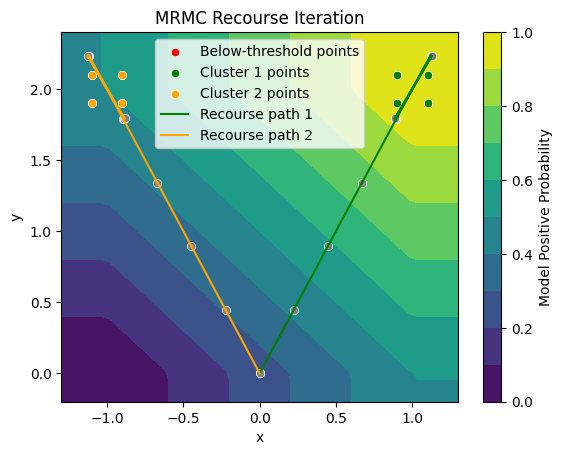

In [44]:
plot_recourse_iteration(
    max_iterations=10,
    step_size=0.5,
    certainty_cutoff=None,
    confidence_threshold=None,
    model=MODEL,
    perturb_ratio=None,
    rescale_ratio=None,
)
plt.title("MRMC Recourse Iteration")

If `certainty_cutoff` is set to 0.9, then:
1. The right cluster path terminates when it reaches the cluster.
2. The left cluster path doesn't terminate because the left cluster has low certainty.

Text(0.5, 1.0, 'Recourse Iteration with Confidence-Based Termination')

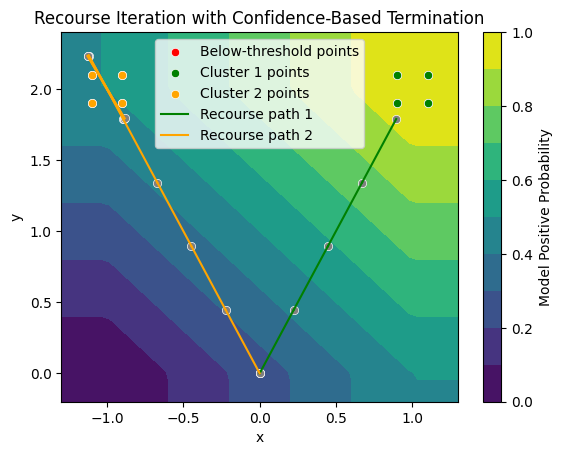

In [45]:
plot_recourse_iteration(
    max_iterations=10,
    step_size=0.5,
    certainty_cutoff=0.9,
    confidence_threshold=None,
    model=MODEL,
    perturb_ratio=None,
    rescale_ratio=None,
)
plt.title("Recourse Iteration with Confidence-Based Termination")

Setting `confidence_threshold` to 0.9 causes both paths to terminate in the right cluster. 

Text(0.5, 1.0, 'Recourse Iteration with Confidence-Based Filtering')

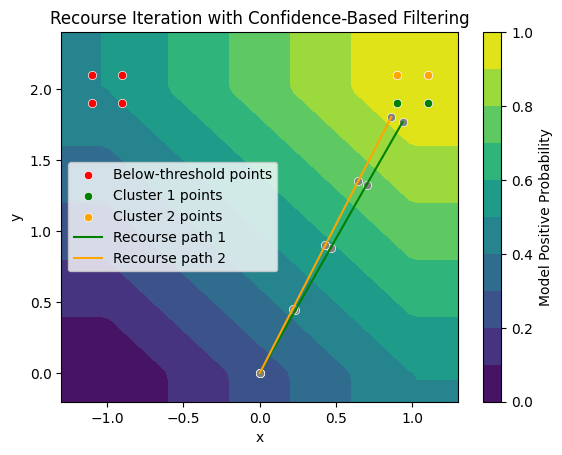

In [46]:
plot_recourse_iteration(
    max_iterations=10,
    step_size=0.5,
    certainty_cutoff=0.9,
    confidence_threshold=0.9,
    model=MODEL,
    perturb_ratio=None,
    rescale_ratio=None,
)
plt.title("Recourse Iteration with Confidence-Based Filtering")

Setting `rescale_ratio` to 0.5 halves the step size.

Text(0.5, 1.0, 'Recourse Iteration with Rescaled Step Size')

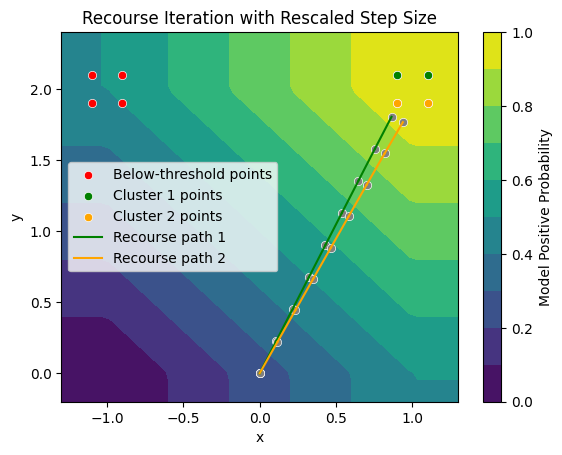

In [47]:
plot_recourse_iteration(
    max_iterations=10,
    step_size=0.5,
    certainty_cutoff=0.9,
    confidence_threshold=0.9,
    model=MODEL,
    perturb_ratio=None,
    rescale_ratio=0.5,
)
plt.title("Recourse Iteration with Rescaled Step Size")

Setting `perturb_ratio` randomly perturbs the direction of each recourse step such that:
1. The perturbations are larger as `perturb_ratio` increases
2. The perturbations don't change the step size


Note that the paths may be perturbed outside of where the model confidence
 contours are rendered, but the confidence is still defined in those areas.

Text(0.5, 1.0, 'Recourse Iteration with Perturbation Ratio 0.1')

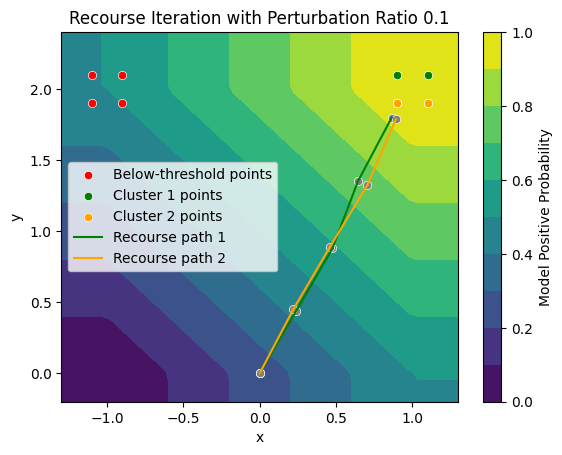

In [48]:
perturb_ratio = 0.1
plot_recourse_iteration(
    max_iterations=10,
    step_size=0.5,
    certainty_cutoff=0.9,
    confidence_threshold=0.9,
    model=MODEL,
    perturb_ratio=perturb_ratio,
    rescale_ratio=None,
)
plt.title(f"Recourse Iteration with Perturbation Ratio {perturb_ratio}")

Text(0.5, 1.0, 'Recourse Iteration with Perturbation Ratio 0.3')

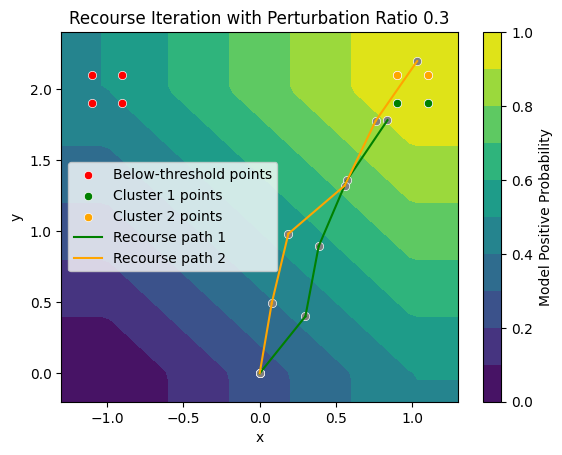

In [49]:
perturb_ratio = 0.3
plot_recourse_iteration(
    max_iterations=10,
    step_size=0.5,
    certainty_cutoff=0.9,
    confidence_threshold=0.9,
    model=MODEL,
    perturb_ratio=perturb_ratio,
    rescale_ratio=None,
)
plt.title(f"Recourse Iteration with Perturbation Ratio {perturb_ratio}")

Text(0.5, 1.0, 'Recourse Iteration with Perturbation Ratio 0.5')

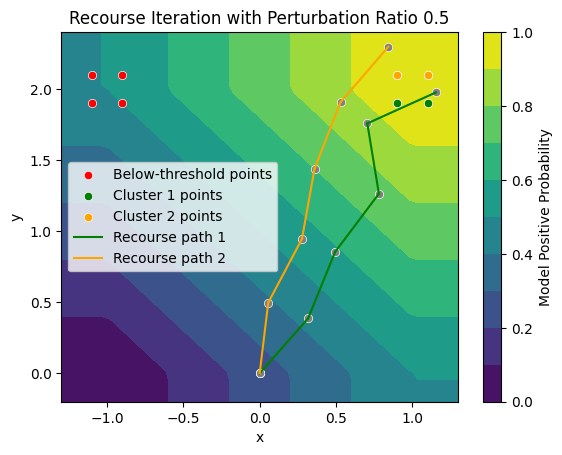

In [50]:
perturb_ratio = 0.5
plot_recourse_iteration(
    max_iterations=10,
    step_size=0.5,
    certainty_cutoff=0.9,
    confidence_threshold=0.9,
    model=MODEL,
    perturb_ratio=perturb_ratio,
    rescale_ratio=None,
)
plt.title(f"Recourse Iteration with Perturbation Ratio {perturb_ratio}")

Text(0.5, 1.0, 'Recourse Iteration with Perturbation Ratio 0.7')

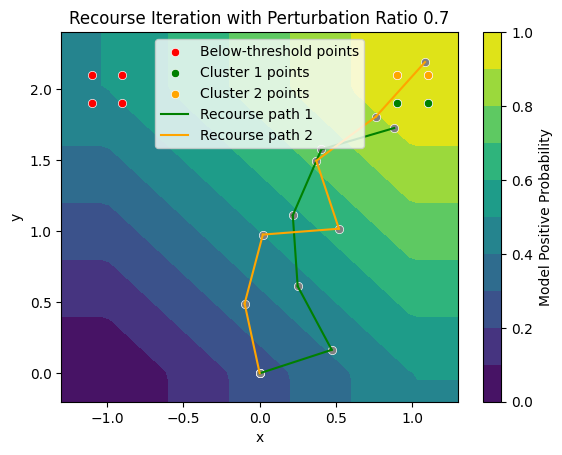

In [51]:
perturb_ratio = 0.7
plot_recourse_iteration(
    max_iterations=10,
    step_size=0.5,
    certainty_cutoff=0.9,
    confidence_threshold=0.9,
    model=MODEL,
    perturb_ratio=perturb_ratio,
    rescale_ratio=None,
)
plt.title(f"Recourse Iteration with Perturbation Ratio {perturb_ratio}")

Text(0.5, 1.0, 'Recourse Iteration with Perturbation Ratio 0.9')

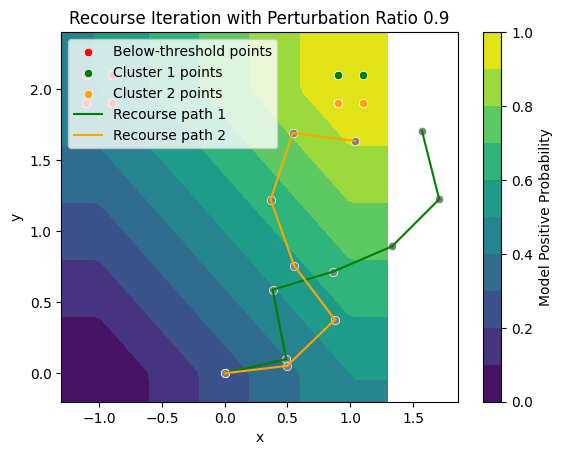

In [52]:
perturb_ratio = 0.9
plot_recourse_iteration(
    max_iterations=10,
    step_size=0.5,
    certainty_cutoff=0.9,
    confidence_threshold=0.9,
    model=MODEL,
    perturb_ratio=perturb_ratio,
    rescale_ratio=None,
)
plt.title(f"Recourse Iteration with Perturbation Ratio {perturb_ratio}")

Text(0.5, 1.0, 'Recourse Iteration with Perturbation Ratio 1.5')

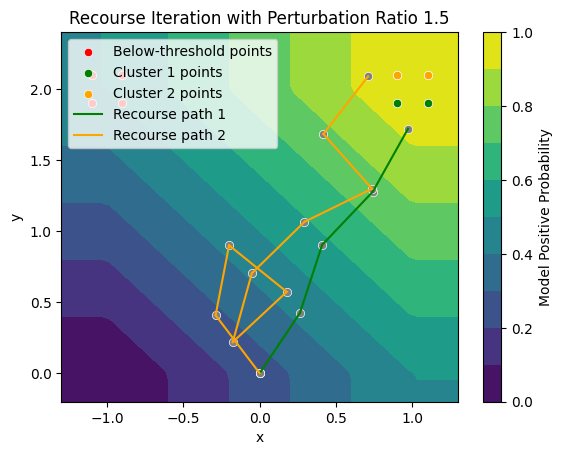

In [53]:
perturb_ratio = 1.5
plot_recourse_iteration(
    max_iterations=10,
    step_size=0.5,
    certainty_cutoff=0.9,
    confidence_threshold=0.9,
    model=MODEL,
    perturb_ratio=perturb_ratio,
    rescale_ratio=None,
)
plt.title(f"Recourse Iteration with Perturbation Ratio {perturb_ratio}")